# Assignment Description

> Use the IOT intrusion detection dataset for a supervised anomaly detection task. The label column indicates whether each row's data is normal or anomalous.
You can choose an ML classifier for training on this dataset.
>
> The task is to build a classifier using the train dataset and deploy a trained model in Sagemaker.
You can use your personal AWS account to do this.
The classifier should be able to generate robust classification metrics on a held-out test/validation dataset. You can use a portion of your train set for validation metrics.
>
> As for output, please send us a link to the code and classification results in your git repository when you are done. Configuration should be through an orchestration system so we can re-create the environment programmatically.
>
> We will use a held-out test set to evaluate your model's performance.
>
> Test data can be found here: [https://github.com/netography/ml-engineer/archive/refs/heads/main.zip](https://github.com/netography/ml-engineer/archive/refs/heads/main.zip)
>
> It can also be found here: [https://www.dropbox.com/scl/fi/oz1fspqu4mago3wxeb9dp/IoT-network-intrustion-dataset-train.csv?rlkey=d6hblxlw4t163tt386w16gldi&dl=0](https://www.dropbox.com/scl/fi/oz1fspqu4mago3wxeb9dp/IoT-network-intrustion-dataset-train.csv?rlkey=d6hblxlw4t163tt386w16gldi&dl=0)

In [189]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager


random.seed(31337)
np.random.seed(31337)
pd.set_option('display.max_columns', 100)

# Load and Evaluate the Flow Logs

In [2]:
train_df = pd.read_parquet("data/ml-engineer-main/iot_network_intrustion_dataset_train.parquet")
train_df = train_df.rename(columns={"Unnamed: 0": "ID"})

train_df.head()

,ID,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,315192,192.168.0.13-192.168.0.16-56361-10101-17,192.168.0.13,56361,192.168.0.16,10101,17,25/07/2019 03:23:29 AM,115,1,1,402.0,1430.0,402.0,402.0,402.0,0.000000,1430.0,1430.0,1430.0,0.000000,1.593043e+07,17391.304348,115.0,0.000000,115.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,8,8,8695.652174,8695.652174,402.0,1430.0,1087.333333,593.516077,352261.333333,0,0,0,0,0,0,0,0,1.0,1631.000000,402.0,1430.0,0,0,0,0,0,0,1,402,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,115.0,0.000000,115.0,115.0,Anomaly,Mirai,Mirai-Ackflooding
1,104915,192.168.0.24-222.239.240.107-57678-443-6,192.168.0.24,57678,222.239.240.107,443,6,20/05/2019 05:00:15 AM,259,0,3,0.0,4344.0,0.0,0.0,0.0,0.000000,1448.0,1448.0,1448.0,0.000000,1.677220e+07,11583.011583,129.5,12.020815,138.0,121.0,0.0,0.0,0.0,0.0,0.0,259.0,129.5,12.020815,138.0,121.0,0,0,0,0,0,96,0.000000,11583.011583,1448.0,1448.0,1448.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,1930.666667,0.0,1448.0,0,0,0,0,0,0,0,0,3,4344,-1,139,0,0,0.0,0.0,0.0,0.0,129.5,12.020815,138.0,121.0,Normal,Normal,Normal
2,363451,192.168.0.13-192.168.0.16-9020-56266-6,192.168.0.16,56266,192.168.0.13,9020,6,10/09/2019 01:47:48 AM,123,0,2,0.0,1418.0,0.0,0.0,0.0,0.000000,1388.0,30.0,709.0,960.251009,1.152846e+07,16260.162602,123.0,0.000000,123.0,123.0,0.0,0.0,0.0,0.0,0.0,123.0,123.0,0.000000,123.0,123.0,0,0,0,0,0,64,0.000000,16260.162602,30.0,1388.0,935.333333,784.041666,614721.333333,0,0,0,0,1,0,0,0,0.0,1403.000000,0.0,709.0,0,0,0,0,0,0,0,0,2,1418,-1,1869,0,0,0.0,0.0,0.0,0.0,123.0,0.000000,123.0,123.0,Anomaly,Mirai,Mirai-Hostbruteforceg
3,477181,192.168.0.13-192.168.0.16-9020-52704-6,192.168.0.16,52704,192.168.0.13,9020,6,11/07/2019 01:12:32 AM,148,0,2,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,1388.0,1388.0,0.000000,1.875676e+07,13513.513514,148.0,0.000000,148.0,148.0,0.0,0.0,0.0,0.0,0.0,148.0,148.0,0.000000,148.0,148.0,0,0,0,0,0,64,0.000000,13513.513514,1388.0,1388.0,1388.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,2082.000000,0.0,1388.0,0,0,0,0,0,0,0,0,2,2776,-1,1869,0,0,0.0,0.0,0.0,0.0,148.0,0.000000,148.0,148.0,Anomaly,Scan,Scan Hostport
4,606027,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:28 AM,282,2,1,1904.0,1430.0,1430.0,474.0,952.0,675.994083,1430.0,1430.0,1430.0,0.000000,1.182270e+07,10638.297872,141.0,70.710678,191.0,91.0,191.0,191.0,0.0,191.0,191.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,16,8,7092.198582,3546.099291,474.0,1430.0,1191.000000,478.000000,228484.000000,0,0,0,0,0,0,0,0,0.0,1588.000000,952.0,1430.0,0,0,0,0,0,0,2,1904,1,1430,-1,-1,2,0,0.0,0.0,0.0,0.0,141.0,70.710678,191.0,91.0,Anomaly,Mirai,Mirai-Ackflooding


In [3]:
train_df.describe()

,ID,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,5.006260e+05,5.006260e+05,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.0,500626.000000,500626.0,500626.000000,500626.000000,500626.000000,5.006260e+05,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.0,500626.0,500626.0,500626.0,500626.0,500626.0,500626.000000,500626.000000,500626.000000,500626.000000,500626.0,500626.000000,500626.000000,500626.0,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000,500626.000000
mean,313032.637084,35045.114962,16392.202506,9.970825,631.768646,1.676425,1.466394,569.632550,926.820031,392.079391,347.845919,373.187747,28.075772,681.141894,588.476344,636.863302,62.921255,inf,inf,482.905193,61.509933,563.190258,443.545141,100.019328,51.632779,27.166793,83.542904,34.131927,513.962859,445.891003,28.053083,484.683185,428.262901,0.0,0.026593,0.0,0.000056,22.478385,33.657996,5.046282e+04,27842.365842,511.434160,699.787768,633.339985,102.517288,69649.683424,0.000539,0.092724,0.000511,0.026593,0.530674,0.000056,0.000216,0.000068,0.364939,914.822026,373.187747,636.863302,0.0,0.0,0.0,0.0,0.0,0.0,1.676425,569.632550,1.466394,926.820031,-1.0,5886.377595,1.511318,0.0,3.678091,0.322559,4.087922,3.399306,501.095183,51.108721,558.971126,466.819931
std,180633.665830,24718.622926,17554.442272,5.380044,3455.950187,4.316453,0.904491,1143.744636,1314.801566,619.338077,587.993156,596.359647,144.160947,694.984157,682.867792,669.554267,227.584442,NaN,NaN,1898.921239,1129.725193,2835.568432,1733.844124,2172.224490,1193.921341,939.169121,1904.676273,987.380186,3112.799071,2234.546802,786.182321,2727.857064,2173.809583,0.0,0.160890,0.0,0.007478,40.852942,30.598958,1.649464e+05,78491.927333,653.887171,696.823235,652.269622,243.187185,179117.562307,0.023217,0.290045,0.022608,0.160890,0.499059,0.007478,0.014686,0.008241,0.499165,948.684981,596.359647,669.554267,0.0,0.0,0.0,0.0,0.0,0.0,4.316453,1143.744636,0.904491,1314.801566,0.0,11540.560492,4.341830,0.0,66.708160,16.269218,78.070821,63.866128,2105.975309,1120.897418,2835.755260,1934.422976
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000540e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [4]:
print(f"{len(train_df):,}")

500,626


In [5]:
test_df = pd.read_parquet("data/ml-engineer-main/iot_network_intrustion_dataset_test.parquet")
test_df = test_df.rename(columns={"Unnamed: 0": "ID"})

test_df.head()

,ID,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,230773,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:05:41 AM,141,2,1,1450.0,20.0,1430.0,20.0,725.0,997.020561,20.0,20.0,20.0,0.0,1.042553e+07,2.127660e+04,70.5,2.121320,72.0,69.0,69.0,69.0,0.0,69.0,69.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,16,8,14184.397163,7092.198582,20.0,1430.0,372.5,705.0,497025.0,0,0,0,0,0,0,0,0,0.0,496.666667,725.0,20.0,0,0,0,0,0,0,2,1450,1,20,-1,-1,2,0,0.0,0.0,0.0,0.0,70.5,2.121320,72.0,69.0,Anomaly,Mirai,Mirai-Hostbruteforceg
1,521223,192.168.0.24-210.89.164.90-64776-9988-17,192.168.0.24,64776,210.89.164.90,9988,17,25/07/2019 03:20:13 AM,1,1,1,32.0,32.0,32.0,32.0,32.0,0.000000,32.0,32.0,32.0,0.0,6.400000e+07,2.000000e+06,1.0,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,8,8,1000000.000000,1000000.000000,32.0,32.0,32.0,0.0,0.0,0,0,0,0,0,0,0,0,1.0,48.000000,32.0,32.0,0,0,0,0,0,0,1,32,1,32,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Anomaly,Mirai,Mirai-UDP Flooding
2,155309,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 04:58:07 AM,482,0,5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,1.037344e+04,120.5,96.334487,265.0,72.0,0.0,0.0,0.0,0.0,0.0,482.0,120.5,96.334487,265.0,72.0,0,0,0,0,0,160,0.000000,10373.443983,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,0,5,0,-1,32505,0,0,0.0,0.0,0.0,0.0,120.5,96.334487,265.0,72.0,Normal,Normal,Normal
3,42560,192.168.0.24-104.118.134.215-43238-443-6,104.118.134.215,443,192.168.0.24,43238,6,25/07/2019 03:21:48 AM,269,1,1,1441.0,1441.0,1441.0,1441.0,1441.0,0.000000,1441.0,1441.0,1441.0,0.0,1.071375e+07,7.434944e+03,269.0,0.000000,269.0,269.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,32,32,3717.472119,3717.472119,1441.0,1441.0,1441.0,0.0,0.0,0,0,0,0,1,0,0,0,1.0,2161.500000,1441.0,1441.0,0,0,0,0,0,0,1,1441,1,1441,-1,252,1,0,0.0,0.0,0.0,0.0,269.0,0.000000,269.0,269.0,Anomaly,Mirai,Mirai-Ackflooding
4,326612,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:03 AM,73,0,2,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,1388.0,1388.0,0.0,3.802740e+07,2.739726e+04,73.0,0.000000,73.0,73.0,0.0,0.0,0.0,0.0,0.0,73.0,73.0,0.000000,73.0,73.0,0,0,0,0,0,64,0.000000,27397.260274,1388.0,1388.0,1388.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,2082.000000,0.0,1388.0,0,0,0,0,0,0,0,0,2,2776,-1,1869,0,0,0.0,0.0,0.0,0.0,73.0,0.000000,73.0,73.0,Anomaly,Scan,Scan Port OS


In [6]:
test_df.describe()

,ID,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
count,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,1.251570e+05,1.251570e+05,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.0,125157.000000,125157.0,125157.000000,125157.000000,125157.000000,1.251570e+05,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.0,125157.0,125157.0,125157.0,125157.0,125157.0,125157.000000,125157.000000,125157.000000,125157.000000,125157.0,125157.000000,125157.000000,125157.0,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000,125157.000000
mean,312324.453926,34950.321404,16366.327453,9.973881,650.039686,1.672132,1.477073,575.164681,939.124699,394.131059,349.249175,375.032257,28.502382,682.555231,589.421311,638.083057,63.270811,inf,inf,485.691985,69.644639,576.339773,441.334636,110.712401,56.046393,29.779069,90.948920,36.868917,528.112235,451.258928,31.740977,494.791718,431.235472,0.0,0.025680,0.0,0.000032,22.538500,33.966075,4.968508e+04,27721.063378,512.491175,701.295069,634.974124,102.697929,69784.619603,0.000479,0.093834,0.000384,0.025680,0.529679,0.000032,0.000168,0.000064,0.363503,916.943221,375.032257,638.083057,0.0,0.0,0.0,0.0,0.0,0.0,1.672132,575.164681,1.477073,939.124699,-1.0,5859.113426,1.504295,0.0,4.109658,0.476690,4.891984,3.713568,508.138405,57.585072,571.818013,469.042563
std,180705.616965,24730.698084,17534.091479,5.379128,3655.330974,4.283955,2.040416,1231.716717,2842.547976,620.525868,588.837133,597.325066,145.134609,695.053098,683.225505,669.602542,228.528024,NaN,NaN,1868.432081,1272.601923,2986.174636,1660.025339,2384.478910,1281.777384,1034.638107,2054.696724,1050.800571,3281.603134,2273.858913,892.983099,2846.363293,2193.845851,0.0,0.158179,0.0,0.005653,44.136902,66.095549,1.622552e+05,78439.864950,654.209225,696.922620,652.452694,243.389047,179223.794858,0.021890,0.291599,0.019580,0.158179,0.499120,0.005653,0.012952,0.007995,0.499108,948.658631,597.325066,669.602542,0.0,0.0,0.0,0.0,0.0,0.0,4.283955,1231.716717,2.040416,2842.547976,0.0,11485.788681,4.296188,0.0,73.238386,32.992821,123.149347,65.081136,2140.656964,1274.170555,2986.293031,1921.831800
min,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.177108e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

In [7]:
print(f"{len(test_df):,}")

125,157


## How are flows unique?

In [8]:
print(f'{len(train_df["ID"].unique()):,}')

500,626


In [9]:
print(f'{len(train_df["Flow_ID"].unique()):,}')

51,873


In [10]:
print(f'{len(train_df[train_df.Flow_ID == "163.152.127.193-192.168.0.13-10101-56361-17"]):,}')

5,984


## This seems like it...

In [11]:
train_df[train_df.Flow_ID == "163.152.127.193-192.168.0.13-10101-56361-17"].sort_values(["Timestamp", "ID"])

,ID,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
218993,71240,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,127,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,2.251969e+07,15748.031496,127.0,0.0,127.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,7874.015748,7874.015748,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,127.0,0.0,127.0,127.0,Anomaly,Mirai,Mirai-Hostbruteforceg
483004,232004,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,168,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,1.702381e+07,11904.761905,168.0,0.0,168.0,168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,5952.380952,5952.380952,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,168.0,0.0,168.0,168.0,Anomaly,Mirai,Mirai-Hostbruteforceg
413738,343336,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,71,1,1,1430.0,1370.0,1430.0,1430.0,1430.0,0.0,1370.0,1370.0,1370.0,0.0,3.943662e+07,28169.014085,71.0,0.0,71.0,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,14084.507042,14084.507042,1370.0,1430.0,1390.000000,34.641016,1200.000000,0,0,0,0,0,0,0,0,1.0,2085.0,1430.0,1370.0,0,0,0,0,0,0,1,1430,1,1370,-1,-1,1,0,0.0,0.0,0.0,0.0,71.0,0.0,71.0,71.0,Anomaly,Mirai,Mirai-Hostbruteforceg
148233,371295,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,117,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,2.444444e+07,17094.017094,117.0,0.0,117.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,8547.008547,8547.008547,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,117.0,0.0,117.0,117.0,Anomaly,Mirai,Mirai-Hostbruteforceg
344622,414818,163.152.127.193-192.168.0.13-10101-56361-17,192.168.0.13,56361,163.152.127.193,10101,17,20/08/2019 03:03:06 AM,121,1,1,1430.0,1430.0,1430.0,1430.0,1430.0,0.0,1430.0,1430.0,1430.0,0.0,2.363636e+07,16528.925620,121.0,0.0,121.0,121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,8,8,8264.462810,8264.462810,1430.0,1430.0,1430.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,1.0,2145.0,1430.0,1430.0,0,0,0,0,0,0,1,1430,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,121.0,0.0,121.0,121.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## Label Check

As we see below, the data is just 6.4% / 6.1% normal event types. I would like to ask a question about this, but at this late date I will go with what I can determine. 

In [12]:
train_label_counts = train_df["Label"].value_counts()

train_normal_pct = (train_label_counts[1] / train_label_counts.sum()) * 100
print(f"Normal label percentage: {train_normal_pct:,.2f}%\n")

train_label_counts

Normal label percentage: 6.43%



Anomaly    468446
Normal      32180
Name: Label, dtype: int64

In [13]:
test_label_counts = test_df["Label"].value_counts()

test_normal_pct = (test_label_counts[1] / test_label_counts.sum()) * 100
print(f"Normal label percentage: {test_normal_pct:,.2f}%\n")

test_label_counts

Normal label percentage: 6.31%



Anomaly    117264
Normal       7893
Name: Label, dtype: int64

### Discussion

We might assume the proportion isn't representative of the problem which means we might perform some sample that oversamples normal data. While I don't know how the data was sampled, I am going to assume it is a representative, random sample... it is the only prior I have evidence for at this time. The problem is thus flipped on its head. We need to detect normal traffic and throw out anomalies.

Perhaps this is a web server? Let's do some more EDA to understand it, so I can feel comfortable about proceeding.

In [14]:
[
    len(train_df["Src_IP"].unique()),
    len(train_df["Dst_IP"].unique()),
]

[46331, 460]

In [15]:
# How many IPs have more than 1 connection?
# ip_counts = train_df.groupby("Dst_IP").filter(lambda x: len(x) > 1)["Dst_IP"].value_counts()

ip_counts = train_df["Dst_IP"].value_counts()
ip_counts

192.168.0.13       131558
192.168.0.16       114589
210.89.164.90      105099
192.168.0.24        68540
222.239.240.107      9016
                    ...  
168.126.63.1            1
222.210.95.147          1
111.84.5.129            1
31.237.26.217           1
52.114.128.44           1
Name: Dst_IP, Length: 460, dtype: int64

<Axes: xlabel='Dst_IP', ylabel='Count'>

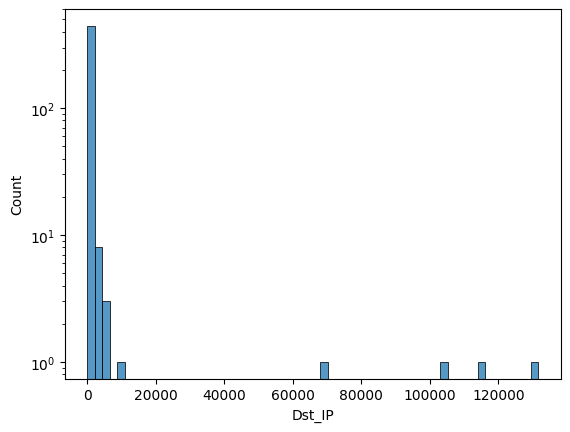

In [16]:
# Time for a histogram!
import seaborn as sns


sns.histplot(data=ip_counts, bins=60, log=True)

In [17]:
# Get a sense of the distribution across destination IPs
dst_label_counts = train_df[["Dst_IP", "Label"]].value_counts().reset_index().sort_values(by=["Dst_IP", "Label"], ascending=[True, False])
dlc_df = dst_label_counts[dst_label_counts["Dst_IP"].str.startswith("192.168.0")]
dlc_df

,Dst_IP,Label,0
346,192.168.0.1,Normal,4
58,192.168.0.1,Anomaly,239
11,192.168.0.13,Normal,3422
0,192.168.0.13,Anomaly,128136
20,192.168.0.14,Normal,1361
18,192.168.0.14,Anomaly,1599
70,192.168.0.15,Anomaly,175
4,192.168.0.16,Normal,25288
2,192.168.0.16,Anomaly,89301
67,192.168.0.23,Normal,195


In [18]:
ip_counts = train_df[["Dst_IP", "Label"]].value_counts().sort_index()
ip_counts = ip_counts.to_frame().rename(columns={0: "count"})
ip_counts

count
Dst_IP       Label         
0.0.0.16     Anomaly      2
             Normal       2
0.0.0.36     Anomaly     34
0.40.0.0     Anomaly      1
0.40.0.1     Anomaly      1
...                     ...
8.8.8.8      Anomaly      1
82.231.1.105 Normal       1
82.231.1.181 Anomaly      1
82.231.1.203 Anomaly      4
96.16.99.81  Anomaly    468

[485 rows x 1 columns]

In [19]:
ip_val_counts = ip_counts.reset_index().rename(columns={"count": "IP_Count"})
ip_val_counts

,Dst_IP,Label,IP_Count
0,0.0.0.16,Anomaly,2
1,0.0.0.16,Normal,2
2,0.0.0.36,Anomaly,34
3,0.40.0.0,Anomaly,1
4,0.40.0.1,Anomaly,1
...,...,...,...
480,8.8.8.8,Anomaly,1
481,82.231.1.105,Normal,1
482,82.231.1.181,Anomaly,1
483,82.231.1.203,Anomaly,4


### Comparing Anomaly / Label Rations per IP

The following histogram is interesting... there is no clear pattern visible in terms of label per destination IP. I am going to stop my EDA here and move on to a baseline unsupervised 

<Axes: xlabel='IP_Count', ylabel='Count'>

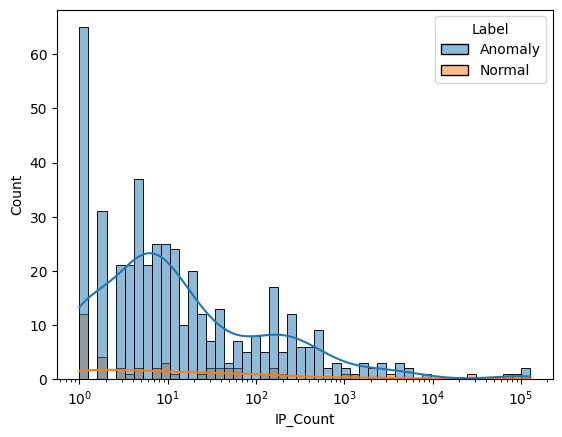

In [20]:
sns.histplot(data=ip_val_counts, x="IP_Count", hue="Label", kde=True, bins=50, log_scale=True)

## Network Visualization

I just have to look at this as a network before moving onto actual machine learning... as I just worked at Graphistry and am familiar with their tool.

### Preparing a Dataset to Visualize

I need to see the network before proceeding onwards because I tend to make fundamental errors when I don't perform this step... sort of like in this exercise - the work I did in CloudFormation to setup a new SageMaker notebook inside a VPC - when I could have just used a SageMaker domain and the SageMaker Python SDK to publish a model very easily. In any case... let's do a first pass visualization.

In [ ]:
viz_df = train_df[["Flow_ID", "Src_IP", "Src_Port", "Dst_IP", "Dst_Port", "Timestamp", "Protocol", "Label"]]
viz_df.head()

In [ ]:
viz_df["src"] = viz_df["Src_IP"] + " / " + viz_df["Src_Port"].astype("str") + " / " + viz_df["Protocol"].astype("str")
viz_df["dst"] = viz_df["Dst_IP"] + " / " + viz_df["Dst_Port"].astype("str") + " / " + viz_df["Protocol"].astype("str")

viz_df.head()

### Are Flow IDs Labeled All or Nothing?

As we will see below - yes they are!

In [ ]:
flow_label_counts = viz_df.groupby(["Flow_ID", "Label"]).count().reset_index()
flow_label_counts = flow_label_counts.rename(columns={"Src_IP": "Count"})[["Flow_ID", "Label", "Count"]]
flow_label_counts

In [ ]:
flow_anomaly_counts = flow_label_counts[flow_label_counts["Label"] == "Anomaly"]
flow_anomaly_counts

In [ ]:
flow_normal_counts = flow_label_counts[flow_label_counts["Label"] == "Normal"]
flow_normal_counts

### Look... a flow ID is all normal or all anomalous, regardless of timestamp :)

There is no overlap between these two datasets. This simplifies visualizing them considerably.

In [ ]:
flow_anomaly_ratio = flow_normal_counts["Count"] / flow_anomaly_counts["Count"]
flow_anomaly_ratio.sum()

### Alter `viz_df` to Account for Label Polarity

Let's dedupe the flows to account for the fact that Flow IDs are always anomalous or not...

In [ ]:
viz_df = viz_df.drop(columns=["Timestamp"], errors="ignore").drop_duplicates()
print(f"Total edges: {len(viz_df):,}")
viz_df

### Setting up Graphistry

I used the GPUs freely available on [Graphistry Hub](https://hub.graphistry.com/) at [https://hub.graphistry.com/](https://hub.graphistry.com/) to visualize the flow logs as a network. It is free for personal use and is powerful for visualizing networks large and small.

You can [signup](https://hub.graphistry.com/accounts/signup/) for a Graphistry account at [https://hub.graphistry.com/accounts/signup/](https://hub.graphistry.com/accounts/signup/). <b>You should use a username/password/email to get the required credentials</b>, although after that you can login with your Github or Google account.

<center><img src="images/graphistry_hub_registration.png" /></center>

Retain and use your credentials in the login form and in the environment variables in the next cell below. You should set the `GRAPHISTRY_USERNAME` and `GRAPHISTRY_PASSWORD` variables in the `env/graphistry.env` file, and then restart this docker container to pickup the new values.

<center><img src="images/graphistry_hub_homepage.png" /></center>

In [ ]:
import os
import graphistry

In [ ]:
# Environment variable setup
GRAPHISTRY_USERNAME = os.getenv("GRAPHISTRY_USERNAME")
GRAPHISTRY_PASSWORD = os.getenv("GRAPHISTRY_PASSWORD")

In [ ]:
graphistry.register(
    api=3,
    username=GRAPHISTRY_USERNAME,
    password=GRAPHISTRY_PASSWORD,
)

In [ ]:
(
    graphistry.edges(viz_df, source="src", destination="dst")
    #.options({""})
    .plot()
)

### 192.168.0.13: Anomalous Real Time Streaming Protocol (RTSP) for Microsoft Windows Media

One interesting thing that pops up immediately is the following image of Graphistry visualizing the flow network, which shows anomalous media serving from a machine.

<center><img alt="192.168.0.13 is an interesting high degree node. The port indicates it is video traffic?" src="images/Netography-Network-Flows-Graphistry-Server.jpg" /></center>
<br />

You can see below that the flows are mostly around the host `192.168.0.13` serving a [Real Time Streaming Protocol (RTSP) for Microsoft Windows Media streaming services and QuickTime Streaming Server (QTSS)](https://www.speedguide.net/port.php?port=554) workload. You can imagine if we were manually feature engineering that a low port (<1024) with a high degree would likely be legitimate.

<br />
<center><img alt="Anomalous 192.168.0.13 is a Windows Media Server" src="images/Netography-Network-Flows-Graphistry-Windows-Media-Server.jpg" /></center>
<br />



Wait... traffic to this server is marked as `Anomaly`. This is very confusing. Things seem reversed once again. I really need to know more about the use case to understand this better... what constitutes normal traffic on this network isn't what I would expect.

## What is Normal?

There is no normal! Ok, well maybe. I now realize I have not actually explored the relatively small number of `Normal` network flows. Filtering down to `Label == "Normal"` edges in Graphistry, we can see this server with SSL traffic:

<center><img alt="Normal SSL Traffic" src="images/Netography-Network-Flows-Graphistry-Normal-SSL-Traffic.jpg" /></center>
<br />

I am going to see how many unique `Normal` flows there are... maybe this is a simple problem :)

In [21]:
short_cols_train_df = train_df[train_df.Dst_IP == "192.168.0.13"][
    ["Flow_ID", "Src_IP", "Src_Port", "Dst_IP", "Dst_Port", "Protocol", "Timestamp", "Label", "Cat", "Sub_Cat"]
]
normal_train_df = short_cols_train_df[short_cols_train_df["Label"] == "Normal"]

# There is only one flow that is normal in the training data, isn't there?
normal_train_df.sort_values(by="Flow_ID")

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Label,Cat,Sub_Cat
248808,192.168.0.13-192.168.0.16-0-0-0,192.168.0.16,0,192.168.0.13,0,0,20/05/2019 04:58:01 AM,Normal,Normal,Normal
110101,192.168.0.13-192.168.0.16-9010-49788-6,192.168.0.16,49788,192.168.0.13,9010,6,20/05/2019 04:57:10 AM,Normal,Normal,Normal
279635,192.168.0.13-192.168.0.16-9010-49788-6,192.168.0.16,49788,192.168.0.13,9010,6,20/05/2019 04:57:11 AM,Normal,Normal,Normal
301359,192.168.0.13-192.168.0.16-9010-49788-6,192.168.0.16,49788,192.168.0.13,9010,6,20/05/2019 04:57:10 AM,Normal,Normal,Normal
129961,192.168.0.13-192.168.0.16-9010-49788-6,192.168.0.16,49788,192.168.0.13,9010,6,20/05/2019 04:57:11 AM,Normal,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...
263976,192.168.0.13-192.168.0.16-9020-49799-6,192.168.0.16,49799,192.168.0.13,9020,6,20/05/2019 05:01:14 AM,Normal,Normal,Normal
263201,192.168.0.13-192.168.0.16-9020-49799-6,192.168.0.16,49799,192.168.0.13,9020,6,20/05/2019 05:01:10 AM,Normal,Normal,Normal
263058,192.168.0.13-192.168.0.16-9020-49799-6,192.168.0.16,49799,192.168.0.13,9020,6,20/05/2019 05:01:09 AM,Normal,Normal,Normal
267079,192.168.0.13-192.168.0.16-9020-49799-6,192.168.0.16,49799,192.168.0.13,9020,6,20/05/2019 05:01:07 AM,Normal,Normal,Normal


In [22]:
normal_train_df["Flow_ID"].value_counts()

192.168.0.13-192.168.0.16-9020-49793-6    1159
192.168.0.13-192.168.0.16-9020-49799-6     858
192.168.0.13-192.168.0.16-9020-49796-6     776
192.168.0.13-192.168.0.16-9020-49789-6     589
192.168.0.13-192.168.0.16-9010-49791-6       7
192.168.0.13-192.168.0.16-9010-49797-6       6
192.168.0.13-192.168.0.16-9010-49794-6       6
192.168.0.13-192.168.0.16-9010-49792-6       5
192.168.0.13-192.168.0.16-9010-49795-6       4
192.168.0.13-192.168.0.16-9010-49798-6       4
192.168.0.13-192.168.0.16-9010-49788-6       4
192.168.0.13-192.168.0.16-9010-49790-6       3
192.168.0.13-192.168.0.16-0-0-0              1
Name: Flow_ID, dtype: int64

### Cheating - Peeking at the Test Data

I just want to make sure that the test data isn't as strange as the training data. And it isn't, it is more diverse.

In [24]:
thin_test_df = test_df[["Flow_ID", "Label", "Src_IP", "Src_Port", "Dst_IP", "Dst_Port", "Protocol"]]

# This data looks... funny. Oh, a network flow can sample the same network connection... flow... one way and another. I think.
thin_test_df[thin_test_df.Label == "Normal"].value_counts().sort_values(ascending=False)

Flow_ID                                 Label   Src_IP        Src_Port  Dst_IP         Dst_Port  Protocol
192.168.0.13-192.168.0.16-9020-49784-6  Normal  192.168.0.13  9020      192.168.0.16   49784     6           6191
192.168.0.13-192.168.0.16-9020-49793-6  Normal  192.168.0.16  49793     192.168.0.13   9020      6            265
192.168.0.24-104.70.122.58-50966-443-6  Normal  192.168.0.24  50966     104.70.122.58  443       6            236
192.168.0.13-192.168.0.16-9020-49799-6  Normal  192.168.0.16  49799     192.168.0.13   9020      6            227
192.168.0.13-192.168.0.16-9020-49796-6  Normal  192.168.0.16  49796     192.168.0.13   9020      6            191
                                                                                                             ... 
192.168.0.13-192.168.0.16-9010-49788-6  Normal  192.168.0.13  9010      192.168.0.16   49788     6              1
192.168.0.1-224.0.0.1-0-0-0             Normal  192.168.0.1   0         224.0.0.1      0        

## EDA Conclusion

I need to wrap this assignment, so I am moving on. This was a good way to get to know network flows better.

# __Feature Engineering__

While we could use something like sentence encoding on our IP addresses and the like, for simplicity let's matricize our features - which are mostly numeric - in the simplest, most direct manner possible.

In [25]:
train_df.columns

Index(['ID', 'Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol',
       'Timestamp', 'Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts',
       'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max',
       'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Mean', 'Fwd_Pkt_Len_Std',
       'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Bwd_Pkt_Len_Mean',
       'Bwd_Pkt_Len_Std', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean',
       'Flow_IAT_Std', 'Flow_IAT_Max', 'Flow_IAT_Min', 'Fwd_IAT_Tot',
       'Fwd_IAT_Mean', 'Fwd_IAT_Std', 'Fwd_IAT_Max', 'Fwd_IAT_Min',
       'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Bwd_IAT_Std', 'Bwd_IAT_Max',
       'Bwd_IAT_Min', 'Fwd_PSH_Flags', 'Bwd_PSH_Flags', 'Fwd_URG_Flags',
       'Bwd_URG_Flags', 'Fwd_Header_Len', 'Bwd_Header_Len', 'Fwd_Pkts/s',
       'Bwd_Pkts/s', 'Pkt_Len_Min', 'Pkt_Len_Max', 'Pkt_Len_Mean',
       'Pkt_Len_Std', 'Pkt_Len_Var', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt',
       'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt',
       'CWE_Flag_Count',

In [29]:
# Dump IDs - this must work on new data. Ignore errors for repeats.
trim_train_df = train_df.drop(columns=["ID", "Flow_ID"], errors="ignore")
trim_train_df.head()

,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,Fwd_Pkt_Len_Mean,Fwd_Pkt_Len_Std,Bwd_Pkt_Len_Max,Bwd_Pkt_Len_Min,Bwd_Pkt_Len_Mean,Bwd_Pkt_Len_Std,Flow_Byts/s,Flow_Pkts/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Tot,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Tot,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Bwd_PSH_Flags,Fwd_URG_Flags,Bwd_URG_Flags,Fwd_Header_Len,Bwd_Header_Len,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Min,Pkt_Len_Max,Pkt_Len_Mean,Pkt_Len_Std,Pkt_Len_Var,FIN_Flag_Cnt,SYN_Flag_Cnt,RST_Flag_Cnt,PSH_Flag_Cnt,ACK_Flag_Cnt,URG_Flag_Cnt,CWE_Flag_Count,ECE_Flag_Cnt,Down/Up_Ratio,Pkt_Size_Avg,Fwd_Seg_Size_Avg,Bwd_Seg_Size_Avg,Fwd_Byts/b_Avg,Fwd_Pkts/b_Avg,Fwd_Blk_Rate_Avg,Bwd_Byts/b_Avg,Bwd_Pkts/b_Avg,Bwd_Blk_Rate_Avg,Subflow_Fwd_Pkts,Subflow_Fwd_Byts,Subflow_Bwd_Pkts,Subflow_Bwd_Byts,Init_Fwd_Win_Byts,Init_Bwd_Win_Byts,Fwd_Act_Data_Pkts,Fwd_Seg_Size_Min,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13,56361,192.168.0.16,10101,17,25/07/2019 03:23:29 AM,115,1,1,402.0,1430.0,402.0,402.0,402.0,0.000000,1430.0,1430.0,1430.0,0.000000,1.593043e+07,17391.304348,115.0,0.000000,115.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,8,8,8695.652174,8695.652174,402.0,1430.0,1087.333333,593.516077,352261.333333,0,0,0,0,0,0,0,0,1.0,1631.000000,402.0,1430.0,0,0,0,0,0,0,1,402,1,1430,-1,-1,1,0,0.0,0.0,0.0,0.0,115.0,0.000000,115.0,115.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.24,57678,222.239.240.107,443,6,20/05/2019 05:00:15 AM,259,0,3,0.0,4344.0,0.0,0.0,0.0,0.000000,1448.0,1448.0,1448.0,0.000000,1.677220e+07,11583.011583,129.5,12.020815,138.0,121.0,0.0,0.0,0.0,0.0,0.0,259.0,129.5,12.020815,138.0,121.0,0,0,0,0,0,96,0.000000,11583.011583,1448.0,1448.0,1448.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,1930.666667,0.0,1448.0,0,0,0,0,0,0,0,0,3,4344,-1,139,0,0,0.0,0.0,0.0,0.0,129.5,12.020815,138.0,121.0,Normal,Normal,Normal
2,192.168.0.16,56266,192.168.0.13,9020,6,10/09/2019 01:47:48 AM,123,0,2,0.0,1418.0,0.0,0.0,0.0,0.000000,1388.0,30.0,709.0,960.251009,1.152846e+07,16260.162602,123.0,0.000000,123.0,123.0,0.0,0.0,0.0,0.0,0.0,123.0,123.0,0.000000,123.0,123.0,0,0,0,0,0,64,0.000000,16260.162602,30.0,1388.0,935.333333,784.041666,614721.333333,0,0,0,0,1,0,0,0,0.0,1403.000000,0.0,709.0,0,0,0,0,0,0,0,0,2,1418,-1,1869,0,0,0.0,0.0,0.0,0.0,123.0,0.000000,123.0,123.0,Anomaly,Mirai,Mirai-Hostbruteforceg
3,192.168.0.16,52704,192.168.0.13,9020,6,11/07/2019 01:12:32 AM,148,0,2,0.0,2776.0,0.0,0.0,0.0,0.000000,1388.0,1388.0,1388.0,0.000000,1.875676e+07,13513.513514,148.0,0.000000,148.0,148.0,0.0,0.0,0.0,0.0,0.0,148.0,148.0,0.000000,148.0,148.0,0,0,0,0,0,64,0.000000,13513.513514,1388.0,1388.0,1388.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,2082.000000,0.0,1388.0,0,0,0,0,0,0,0,0,2,2776,-1,1869,0,0,0.0,0.0,0.0,0.0,148.0,0.000000,148.0,148.0,Anomaly,Scan,Scan Hostport
4,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:28 AM,282,2,1,1904.0,1430.0,1430.0,474.0,952.0,675.994083,1430.0,1430.0,1430.0,0.000000,1.182270e+07,10638.297872,141.0,70.710678,191.0,91.0,191.0,191.0,0.0,191.0,191.0,0.0,0.0,0.000000,0.0,0.0,0,0,0,0,16,8,7092.198582,3546.099291,474.0,1430.0,1191.000000,478.000000,228484.000000,0,0,0,0,0,0,0,0,0.0,1588.000000,952.0,1430.0,0,0,0,0,0,0,2,1904,1,1430,-1,-1,2,0,0.0,0.0,0.0,0.0,141.0,70.710678,191.0,91.0,Anomaly,Mirai,Mirai-Ackflooding


In [30]:
trim_train_df.dtypes.value_counts()

float64    45
int64      34
object      6
dtype: int64

## String Columns

I am going to ordinal encode the string columns. `Cat` and `Sub_Cat` in particular look useful. [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) in scikit-learn over label encoding allows for new values to be encoded once the model is deployed.

### Timestamp...

Not sure what to do with timestamp... it should be relative, but to what? We have lots of other metrics about time. Probably a difference between it and the previous flow log.

Leaving it out on a first pass. I will window function a diff from the last value if need be.

In [232]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


def feature_engineer(df):
    """Prepare the features for the anomaly detection.
    
    Takes a DataFrame with a 'Label' column. Returns x and y."""

    # Split a string only pd.DataFrame
    str_cols = list(df.columns[df.dtypes == "object"].values)
    str_cols_no_dt = [x for x in str_cols if x not in ("Label", "Timestamp")]
    str_df = df[str_cols_no_dt]

    # Encode unknown values as -1 as this is for production - retrain to pickup the new flow IPs, etc.
    X_encoder = OrdinalEncoder(
        categories="auto",
        handle_unknown="use_encoded_value",
        unknown_value=-1,
    )
    X_str = X_encoder.fit_transform(str_df)

    # Split off a numeric pd.DataFrame
    numeric_df = df.drop(columns=str_cols, errors="ignore")

    # We have np.inf as values - make them np.inf for processing below
    numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
    X_numeric = numeric_df.values

    # Combine the fixed up strings and numbers
    X_combo = np.append(X_numeric, X_str, axis=1)

    # Fill in the np.infs with column means
    feature_col_means = np.nanmean(X_combo, axis=0)
    nan_indices = np.where(np.isnan(X_combo))
    X_combo[nan_indices] = np.take(feature_col_means, nan_indices[1])

    # Standard scale the features
    standard_scaler = StandardScaler(
        copy=True,
        with_mean=True,
        with_std=True,
    )
    X = standard_scaler.fit_transform(X_combo)

    # Now ordinal encode the labels
    y_str = df["Label"].values.reshape(-1,1)

    y_encoder = OrdinalEncoder(
        categories=[["Normal", "Anomaly"]],
        handle_unknown="use_encoded_value",
        unknown_value=-1,
    )
    y = y_train_encoder.fit_transform(y_str)

    return X, y

In [237]:
X_train, y_train = feature_engineer(train_df)
X_test, y_test = feature_engineer(test_df)

## Unsupervised Anomaly Detection

Now we arrive at the actual anomaly detection. I am starting with unsupervised models, out of curiousity about whether they can handle the task or not - as rated by the labels provided. I will start with a k-means model. I will UMAP plot the data, followed by a baseline PyOD model.

In [238]:
import numpy as np
from sklearn.cluster import KMeans


# Fit the k-means algorithm to the dataset
kmeans = KMeans(n_clusters=5).fit(X_train)

# Get the distances of each point to its nearest cluster
distances = kmeans.transform(X_train)
nearest_distances = np.min(distances, axis=1)

# Define a threshold for anomaly detection
threshold = np.percentile(nearest_distances, 95)

# Identify anomaly indices
knn_anomalies = np.where(nearest_distances > threshold)[0]
knn_normal    = np.where(nearest_distances < threshold)[0]

# Print the indices of the anomalies
print("Anomalies:", knn_anomalies)
knn_anomalies.shape, knn_normal.shape

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Anomalies: [    33    106    141 ... 500608 500612 500621]


((25032,), (475594,))

In [239]:
knn_anomaly_true_labels = train_df.loc[knn_anomalies]["Label"].value_counts()
knn_anomaly_true_labels

Anomaly    23224
Normal      1808
Name: Label, dtype: int64

In [240]:
true_positives =  knn_anomaly_true_labels[1] / knn_anomaly_true_labels.sum()
false_positives = knn_anomaly_true_labels[0] / knn_anomaly_true_labels.sum()
true_positives, false_positives

(0.07222754873761585, 0.9277724512623842)

In [241]:
knn_normal_true_labels = (train_df.loc[knn_normal]["Label"] == "Normal").value_counts()
knn_normal_true_labels

False    445222
True      30372
Name: Label, dtype: int64

In [242]:
true_positives =  knn_normal_true_labels[1] / knn_normal_true_labels.sum()
false_positives = knn_normal_true_labels[0] / knn_normal_true_labels.sum()
true_positives, false_positives

(0.06386119252976279, 0.9361388074702373)

### KMeans Doesn't Work

This method doesn't work - and I am sure I have done something wrong. I am moving on to LIBRARIES. KMeans isn't a great method anyway, we have *`Label`s*.

### UMAP Plot

One last thing... I want to see this thing in a UMAP to see if it can be done without labels.

In [172]:
import umap


reducer = umap.UMAP()

In [176]:
# I take a long time to run!
X_embedding = reducer.fit_transform(X_train)
X_embedding

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


array([[ 0.3118767,  2.890684 ],
       [ 3.3039463, -1.2299362],
       [ 2.9783492,  9.070131 ],
       ...,
       [ 8.951331 ,  9.8451605],
       [12.22271  , -1.3494518],
       [-2.5743065, -0.9843691]], dtype=float32)

In [225]:
# Random sample rows...
sample_size = 3000
sample_indices = np.random.choice(X_embedding.shape[0], sample_size, replace=False)

X_embedding_sample = X_embedding[sample_indices]
X_embedding_sample.shape

(3000, 2)

In [226]:
umap_df = pd.DataFrame(X_embedding_sample, columns=["x", "y"])
umap_df

,x,y
0,2.736346,1.682606
1,10.509249,-4.840947
2,2.307782,6.011285
3,16.618252,2.325025
4,7.015944,15.493294
...,...,...
2995,-2.418819,10.162566
2996,2.340574,5.655151
2997,17.018850,11.976954
2998,2.037357,-1.781879


In [227]:
y_train_sample = y_train[sample_indices].ravel()
y_train_sample.shape

(3000,)

<Axes: xlabel='x', ylabel='y'>

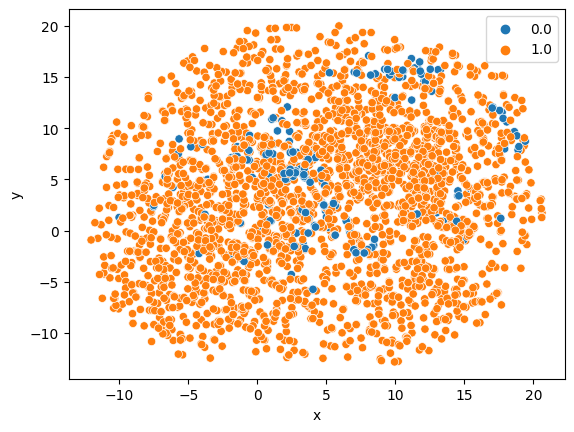

In [228]:
sns.scatterplot(umap_df, x="x", y="y", hue=y_train_sample)

### UMAP Interpretation

Ok, there doesn't seem to be an easily differentiable set of anomalies without labels... we need supervised learning (we have `Label`s!).

## __Supervised Learning for Anomaly Detection__

An unsupervised approach did not work well, so we turn to a supervised approach.

### Scoring Anomaly Detection Algorithms

We need a consistent way to score the anomaly detection methods that deals with label imbalance. Normal traffic is only 6.4% of the training data and 6.1% of the test data, accuracy isn't going to work very well. To remind myself of which metrics are important, I will elaborate.

--Note, the metrics below are defined for _binary classification_ but extend to multi-class.

#### Accuracy: Problematic

Accuracy can be a bad metric with imbalanced data, as always guessing the majority label `Anomaly` will result in 93.9% accuracy on the test data. We need to evaluate precision and recall.

#### Precision vs Recall

It is helpful for me to spell this out, as I am in the middle of writing a machine learning class anyway :)

<center><img alt="Precision vs Recall" src="images/Precision_Recall.webp" /></center>

* __Precision__ measures the number of correct positive labels out of all the positive predictions. Precision is the true predictions, divided by the total `Anomaly` predictions.

    How many `Anomalies` are relevant? Note, precision does not distinguish between the two labels.

* __Recall__ or __True Positive Rate__ measures the number of true positives divided by the total number of positives - true and false positives. Recall is the true predictions, divided by the total true labels, whether true or false.

    How many real `Anomalies` are detected? Note, precision does not distinguish between the two labels.

<center><img alt="Precision and Recall Equations" src="images/Precision_Recall_Equations.webp" /></center>

* __F1 Score__ measures class wise performance. It combines precision and recall into a single value to measure _the overall accuracy of the model in identifying anomalies (positives) while considering both false positives and false negatives_.

<center><img alt="F1 Score" src="images/F1_Score.webp" width="450px" /></center>
<br />

-- Diagrams in this section come from [What’s the deal with Accuracy, Precision, Recall and F1?](https://towardsdatascience.com/whats-the-deal-with-accuracy-precision-recall-and-f1-f5d8b4db1021), [F1 Score in Machine Learning: Intro & Calculation](https://www.v7labs.com/blog/f1-score-guide) and Wikipedia.

#### Confusion Matrix

We will create a confusion matrix for both labels: `Normal` and `Anomaly` to get a clear picture. We have to think about our priorities in terms of our use case... which I am not completely familiar with.

<center><img alt="Confusion Matrix" src="images/Confusion_Matrix.webp" /></center>

In [221]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score


def score_model(model, y_true, y_pred):
    """Score an anomaly detection model in terms of accuracy, precision, recall, a confusion matrix, and F1."""
    scores = {
        "accuracy": accuracy_score(y_true, y_pred),
        # Note: average="binary" is the default
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
    }
    return scores

## PyOD

PyOD is the leading anomaly detection library...

In [222]:
from scipy import stats
from pyod.models.knn import KNN 
from pyod.utils.data import generate_data, get_outliers_inliers

In [229]:
# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [230]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# It is possible to get the prediction confidence as well
y_test_pred, y_test_pred_confidence = clf.predict(X_test, return_confidence=True)  # outlier labels (0 or 1) and confidence in the range of [0,1]

NameError: name 'X_test' is not defined

## PyGOD

Now modeling as a GNN...